# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Определим рыночную стоимость объектов недвижимости. Для этого проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

In [301]:
import pandas as pd
import matplotlib.pyplot as plt

In [302]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [303]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

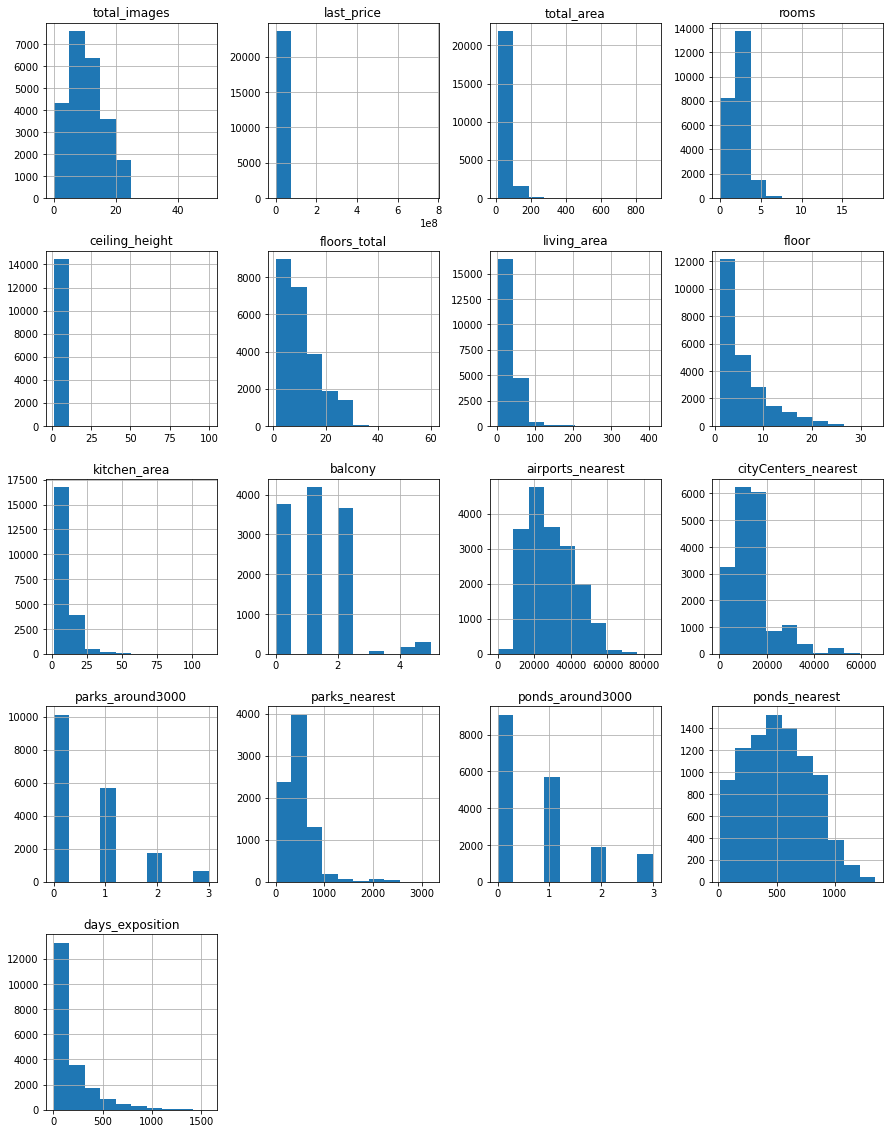

In [304]:
data.hist(figsize=(15, 20));

Визуализировала все необходимые показатели с помощью гистограмм. 

Показатели необходимо проверить на аномалии, восполнить пропуски, убрать нетипичные значения и провести предобработку данных

## Предобработка данных

In [305]:
print(data.shape)
data.isna().sum() #счиаем кол-во пропущенных значений

(23699, 22)


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски в информации о наличии балкона в квартире (столбец balcony) можно заменить 0, так как раз продавец не указал данную информацию, скорее всего этих балкона просто нет. Та же ситуация и с данными, является ли жилье апартаментами (is_apartment) - если данные не заполнены, то, скорее всего, это не апартаменты.

Данные о кол-ве ближайших парков, прудов (parks_around3000, ponds_around3000) были занесены автоматически на основе картографических данных, и пропуски могут означать, что парков, прудов поблизости нет.

Пропуски в "высота потолка" (ceiling_height) возможны из-за того, что в данных квартирах потолки низкие, что может оттолкнуть покупателя, и поэтому продавец не стал указывать эту информацию. По той же причине возможны пропуске и в данных о жилой площади (living_area). Это важная информация для покупателя, но по каким-то соображениям продавец не стал указывать данную информацию.

Квартиры, с пропущенными данными о расстоянии до ближайшего центра города (cityCenters_nearest),   скорее всего пропущенны из-за ошибки в выгрузке данных, и об этом стоит сообщить в отчете, так как эта информация важна для потенциальных покупателей.

А вот пропуски в данных о расстоянии до ближайшего аэропорта (airports_nearest), пруда (ponds_nearest), парка (parks_nearest), могут означать, что жилье находится чересчур далеко от них, и смысла указывать такое расстояние не имеет смысла.

In [306]:
data['is_apartment'] = data['is_apartment'].fillna(False) #заменяем пропуски на False
data['is_apartment'].unique()

array([False,  True])

In [307]:
data['balcony'] = data['balcony'].fillna(0) #заполняем пропуски на 0
data['balcony'] = data['balcony'].astype('int') #изменяем тип данных на integer
print(data['balcony'].unique())

[0 2 1 5 4 3]


In [308]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

1. Заменим пропущенные значения в данных о кол-ве дней, которое объявление было размещено (days_exposition), медианным значением.

2. Данные о расстоянии до ближайшего парка/пруда заменим на медианное расстояние группы, к которой относится жилье. Группы выделим по кол-ву парков и прудов в радиусе 3 км. Данные жилья, по близости которого нет парка,пруда, остануться NA.

In [309]:
len(data['locality_name'].unique()) #уникальные названия насел.пункотов до обработки

365

In [310]:
#чистим данные с наименованием населенного пункта
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е').replace(['городской поселок', 'коттеджный поселок', 'поселок городского типа'], 'поселок', regex=True)

print(data['locality_name'].isna().sum())
data['locality_name'].isna().mean()

49


0.002067597788936242

В 49 объявлениях не указан населенный пункт. Такие объявления составляют всего 0.2% из общей выборки, поэтому их множно просто удалить.

In [311]:
data = data[~data['locality_name'].isna()]

In [312]:
len(data['locality_name'].unique()) 

321

In [313]:
data['locality_name'].isna().sum() #проверка на кол-во пропусков

0

In [315]:
koef_area = (data.query('~living_area.isna()').groupby('rooms')['living_area'].sum() \
/ data.query('~living_area.isna()').groupby('rooms')['total_area'].sum()).to_frame()
koef_area.columns = ['koef']
koef_area = koef_area.reset_index()
koef_area.columns

Index(['rooms', 'koef'], dtype='object')

In [316]:
data = data.merge(koef_area, on = 'rooms', how='left')

In [317]:
data['living_area'] = data['living_area'].fillna(data['total_area']*data['koef'])

In [318]:
data['living_area'].isna().sum()

0

In [319]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000            0
parks_nearest           15586
ponds_around3000            0
ponds_nearest           14565
days_exposition          3180
koef                        0
dtype: int64

In [320]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23649
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               23650 non-null  int64  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [321]:
data.shape

(23650, 23)

1. Дату публикации объявления (first_day_exposition) необходимо из типа данных object перевести в datetime, чтобы использовать позвожности Python для вычисления времени
2. Общее кол-во этажей (floors_total) перевести в int64 - оно всегда целочисленное
3. Кол-во парков и прудов в радиусе 3 км (parks_around3000, ponds_around3000) перевести в int64 - кол-во также целочисленное
4. Кол-во дней размещения объявления (days_exposition) перевести в int64 - всегда целочисленное

In [322]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['last_price'] = data['last_price'].astype('int')

data['floors_total'] = data['floors_total'].fillna(-1) #для перевода в int, для выделения на графике NA
data['floors_total'] = data['floors_total'].astype('int')

In [323]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23649
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        14490 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          21381 non-null  float64       
 13  balcony         

## Новые столбцы в данных:

In [324]:
data['metre_price'] = (data['last_price'] / data['total_area']).round(2)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,koef,metre_price
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,0.612030,120370.37
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.600000,1,False,...,поселок шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,0.477421,82920.79
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.300000,4,False,...,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,0.569304,92785.71
3,0,64900000,159.0,2015-07-24,3,NaN,14,97.312694,9,False,...,санкт-петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,0.612030,408176.10
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,0.569304,100000.00


In [325]:
data['weekday_publicatin'] = data['first_day_exposition'].dt.weekday
data['month_publication'] = data['first_day_exposition'].dt.month
data['year_publication'] = data['first_day_exposition'].dt.year
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,koef,metre_price,weekday_publicatin,month_publication,year_publication
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,1,482.0,2,755.0,NaN,0.612030,120370.37,3,3,2019
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.600000,1,False,...,0,NaN,0,NaN,81.0,0.477421,82920.79,1,12,2018
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.300000,4,False,...,1,90.0,2,574.0,558.0,0.569304,92785.71,3,8,2015
3,0,64900000,159.0,2015-07-24,3,NaN,14,97.312694,9,False,...,2,84.0,3,234.0,424.0,0.612030,408176.10,4,7,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,2,112.0,1,48.0,121.0,0.569304,100000.00,1,6,2018


In [326]:
def floor_typization(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
        
data['floor_type'] = data.apply(floor_typization, axis=1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,koef,metre_price,weekday_publicatin,month_publication,year_publication,floor_type
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2,755.0,NaN,0.612030,120370.37,3,3,2019,другой
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.600000,1,False,...,NaN,0,NaN,81.0,0.477421,82920.79,1,12,2018,первый
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.300000,4,False,...,90.0,2,574.0,558.0,0.569304,92785.71,3,8,2015,другой
3,0,64900000,159.0,2015-07-24,3,NaN,14,97.312694,9,False,...,84.0,3,234.0,424.0,0.612030,408176.10,4,7,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1,48.0,121.0,0.569304,100000.00,1,6,2018,другой


In [327]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,koef,metre_price,weekday_publicatin,month_publication,year_publication,floor_type,cityCenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,2,755.0,NaN,0.612030,120370.37,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.600000,1,False,...,0,NaN,81.0,0.477421,82920.79,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.300000,4,False,...,2,574.0,558.0,0.569304,92785.71,3,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,NaN,14,97.312694,9,False,...,3,234.0,424.0,0.612030,408176.10,4,7,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,1,48.0,121.0,0.569304,100000.00,1,6,2018,другой,8.0


In [328]:
for i in data.columns:
    print(i)

total_images
last_price
total_area
first_day_exposition
rooms
ceiling_height
floors_total
living_area
floor
is_apartment
studio
open_plan
kitchen_area
balcony
locality_name
airports_nearest
cityCenters_nearest
parks_around3000
parks_nearest
ponds_around3000
ponds_nearest
days_exposition
koef
metre_price
weekday_publicatin
month_publication
year_publication
floor_type
cityCenters_nearest_km


## Исследовательский анализ данных

<H3> Общая площадь </H3>

Доля объявлений с общей площадью более 400 кв.м.: 0.00097
Всего объявлений: 23650


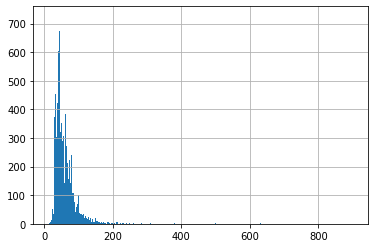

In [329]:
data['total_area'].hist(bins=1000);
print('Доля объявлений с общей площадью более 400 кв.м.:', \
      round(data[data['total_area'] > 400]['total_area'].count() / data['total_area'].count(), 5))
print('Всего объявлений:', data.shape[0])

Всего объявлений: 23627


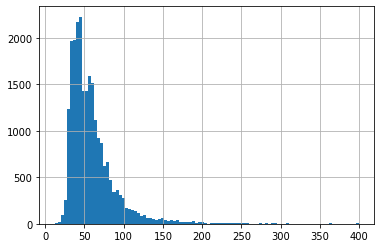

In [330]:
data = data.query('total_area <= 400 | total_area.isna()')
data['total_area'].hist(bins=100);
print('Всего объявлений:', data.shape[0])

<H3> Жилая площадь </H3>

Доля объявлений с жилой площадью более 200 кв.м.: 0.00089
Всего объявлений: 23627


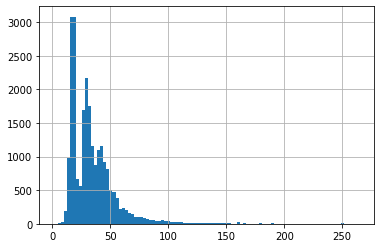

In [331]:
data['living_area'].hist(bins=100);
print('Доля объявлений с жилой площадью более 200 кв.м.:', \
      round(data[data['living_area'] > 200]['living_area'].count() / data['living_area'].count(), 5))
print('Всего объявлений:', data.shape[0])

Всего объявлений: 23606


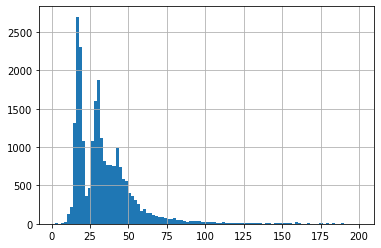

In [332]:
data = data.query('living_area <= 200 | living_area.isna()')
data['living_area'].hist(bins=100);
print('Всего объявлений:', data.shape[0])

<H3> Площадь кухни </H3>

Доля объявлений с площадью кухни более 50 кв.м.: 0.00178
Всего объявлений: 23606


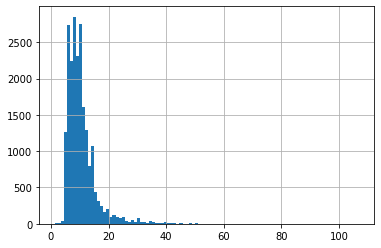

In [333]:
data['kitchen_area'].hist(bins=100);
print('Доля объявлений с площадью кухни более 50 кв.м.:', \
      round(data[data['kitchen_area'] > 50]['kitchen_area'].count() / data['kitchen_area'].count(), 5))
print('Всего объявлений:', data.shape[0])

Всего объявлений: 23568


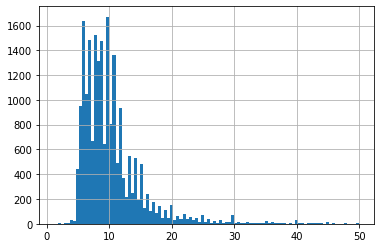

In [334]:
data = data.query('kitchen_area <= 50 | kitchen_area.isna()')
data['kitchen_area'].hist(bins=100);
print('Всего объявлений:', data.shape[0])

<H3> Цена объекта </H3>

Доля объявлений с ценой объекта более 90 000 000 руб.: 0.00102
Всего объявлений: 23568


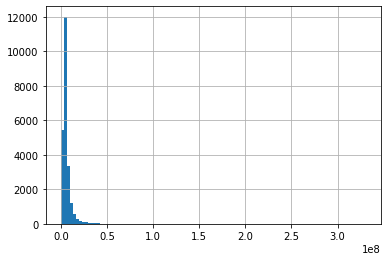

In [335]:
data['last_price'].hist(bins=100);
print('Доля объявлений с ценой объекта более 90 000 000 руб.:', \
      round(data[data['last_price'] > 90000000]['last_price'].count() / data['last_price'].count(), 5))
print('Всего объявлений:', data.shape[0])

Всего объявлений: 23544


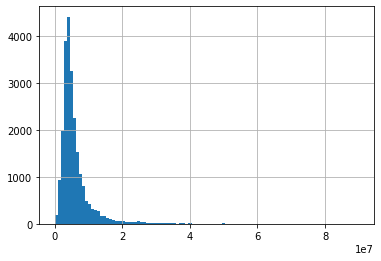

In [336]:
data = data.query('last_price <= 90000000 | last_price.isna()')
data['last_price'].hist(bins=100);
print('Всего объявлений:', data.shape[0])

<H3> Количество комнат </H3>

Доля объявлений с кол-вом комнат более 7: 0.00098
Всего объявлений: 23544


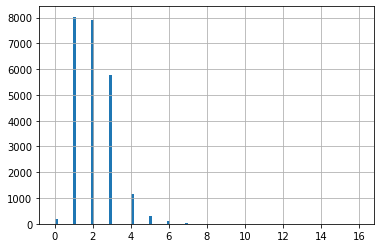

In [337]:
data['rooms'].hist(bins=100);
print('Доля объявлений с кол-вом комнат более 7:', \
      round(data[data['rooms'] > 7]['rooms'].count() / data['rooms'].count(), 5))
print('Всего объявлений:', data.shape[0])

<H3> Высота потолков </H3>

Доля объявлений с высотой полотков более 11 м.: 0.00166


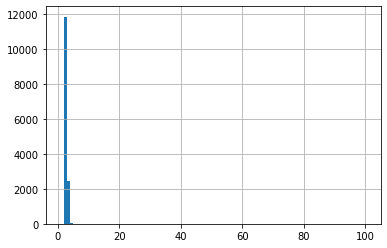

In [338]:
data['ceiling_height'].hist(bins=100);
print('Доля объявлений с высотой полотков более 11 м.:', \
      round(data[data['ceiling_height'] > 11]['ceiling_height'].count() / data['ceiling_height'].count(), 5))

In [339]:
data.query('ceiling_height > 15') #потолки выше 11 метров вызывают сомнения

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,koef,metre_price,weekday_publicatin,month_publication,year_publication,floor_type,cityCenters_nearest_km
355,17,3600000,55.2,2018-07-12,2,25.0,5,32.0,2,False,...,0,NaN,259.0,0.569304,65217.39,3,7,2018,другой,NaN
3144,14,2900000,75.0,2018-11-12,3,32.0,3,53.0,2,False,...,0,NaN,NaN,0.612030,38666.67,0,11,2018,другой,NaN
4636,0,4300000,45.0,2018-02-01,2,25.0,9,30.0,2,False,...,1,331.0,181.0,0.569304,95555.56,3,2,2018,другой,13.0
4868,7,3000000,25.0,2017-09-27,0,27.0,25,17.0,17,False,...,0,NaN,28.0,0.682468,120000.00,2,9,2017,другой,NaN
5068,0,3850000,30.5,2018-10-03,1,24.0,5,19.5,1,True,...,1,578.0,7.0,0.477421,126229.51,2,10,2018,первый,8.0
5238,0,2500000,54.0,2017-10-13,2,27.0,5,30.0,3,False,...,0,NaN,540.0,0.569304,46296.30,4,10,2017,другой,NaN
5660,4,4400000,50.0,2017-08-08,2,26.0,9,21.3,3,False,...,0,NaN,267.0,0.569304,88000.00,1,8,2017,другой,11.0
5797,17,8150000,80.0,2019-01-09,2,27.0,36,41.0,13,False,...,3,80.0,38.0,0.569304,101875.00,2,1,2019,другой,20.0
6236,6,3300000,44.4,2019-03-25,2,25.0,5,31.3,5,False,...,2,73.0,NaN,0.569304,74324.32,0,3,2019,последний,51.0
9363,5,3950000,42.0,2017-03-26,3,25.0,5,30.0,2,False,...,0,NaN,NaN,0.612030,94047.62,6,3,2017,другой,14.0


Очевидно, что все высоты потолков нужно уменьшить в 10 раз. Такая ошибка могла возникнуть из-за невнимательности заполнения продавцом объявления, либо, например, из-за использовании неверного знака, разделяющего целые числа и дровные (точка и запятая)

Пропусков: 9128
Доля объявлений с высотой полотков более 5 м.: 0.00069
Доля объявлений с высотой полотков менее 2 м.: 0.00534
Всего объявлений: 23544


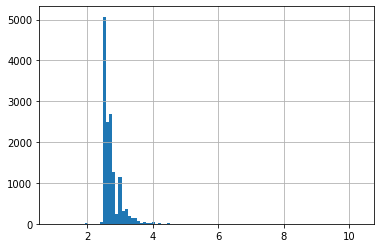

In [340]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 14, data['ceiling_height'] / 10)
data['ceiling_height'].hist(bins=100);
print('Пропусков:', data['ceiling_height'].isna().sum())
print('Доля объявлений с высотой полотков более 5 м.:', \
      round(data[data['ceiling_height'] > 5]['ceiling_height'].count() / data['ceiling_height'].count(), 5))
print('Доля объявлений с высотой полотков менее 2 м.:', \
      round(data[data['ceiling_height'] < 2.5]['ceiling_height'].count() / data['ceiling_height'].count(), 5)) 
#минимальный стандарт для жилых помещений - 2.5м

print('Всего объявлений:', data.shape[0])

In [341]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
print('Пропусков:', data['ceiling_height'].isna().sum())

Пропусков: 0


Всего объявлений: 23457


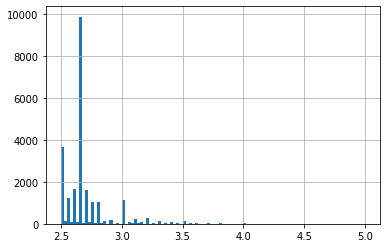

In [342]:
data = data.query('(ceiling_height <= 5 & ceiling_height >=2.5) | ceiling_height.isna()')
data['ceiling_height'].hist(bins=100);
print('Всего объявлений:', data.shape[0])

<H3> Тип этажа квартиры </H3>

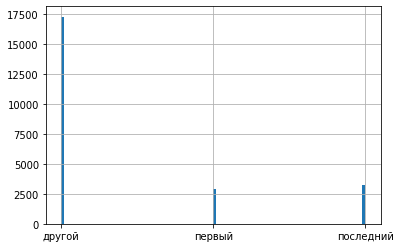

In [343]:
data['floor_type'].hist(bins=100);

Данные выглядят нормально, кол-во квартир на 1м этаже приблизительно равно кол-ву квартир на последнем. 

<H3> Общее количество этажей в доме </H3>

Доля объявлений с кол-вом этажей в квартире более 30: 0.00021
Доля объявлений с кол-вом этажей в квартире менее 0: 0.00362
Всего объявлений: 23457


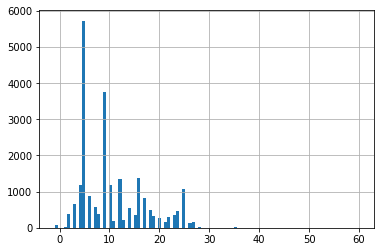

In [344]:
data['floors_total'].hist(bins=100);
print('Доля объявлений с кол-вом этажей в квартире более 30:', \
      round(data[data['floors_total'] > 35]['floors_total'].count() / data['floors_total'].count(), 5))
print('Доля объявлений с кол-вом этажей в квартире менее 0:', \
      round(data[data['floors_total'] <= 0]['floors_total'].count() / data['floors_total'].count(), 5))
print('Всего объявлений:', data.shape[0])

<H3> Расстояние до центра города в метрах </H3>

Всего пропусков в показателе: 5476
Доля объявлений с расстоянием до центра города в метрах более 55 000 м.: 0.00067
Всего объявлений с расстоянием до центра города в метрах более 55 000 м.: 12
Всего объявлений: 23457


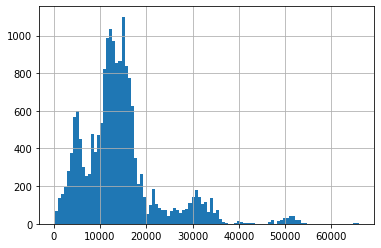

In [345]:
data['cityCenters_nearest'].hist(bins=100);
print('Всего пропусков в показателе:', data['cityCenters_nearest'].isna().sum())
print('Доля объявлений с расстоянием до центра города в метрах более 55 000 м.:', \
      round(data[data['cityCenters_nearest'] > 55000]['cityCenters_nearest'].count() / data['cityCenters_nearest'].count(), 5))
print('Всего объявлений с расстоянием до центра города в метрах более 55 000 м.:', data[data['cityCenters_nearest'] > 55000]['cityCenters_nearest'].count())
print('Всего объявлений:', data.shape[0])

<H3> Расстояние до ближайшего парка </H3>

Всего пропусков в показателе: 15502
Всего объявлений: 23457


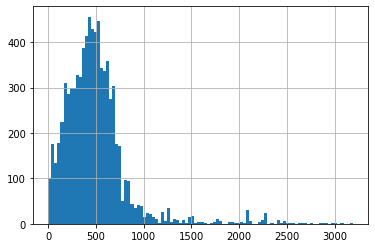

In [346]:
data['parks_nearest'].hist(bins=100); #ничего удалять не нужно, выбросов нет
print('Всего пропусков в показателе:', data['parks_nearest'].isna().sum()) 

print('Всего объявлений:', data.shape[0])

<H3> Промежуточный вывод </H3>

Из 23 650 данных, выбросы содержало 193, или же 0.8%. 

После удаления аномальных значений, осталось 23 457 объявлений

<H3> Насколько быстро продавалось жилье</H3>

count    20309.000000
mean       180.395293
std        219.586317
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64


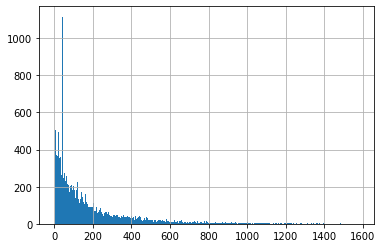

In [348]:
data['days_exposition'].hist(bins=500)
print(data['days_exposition'].describe())

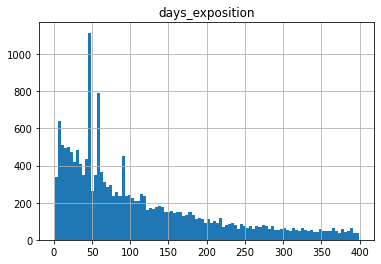

In [353]:
data.query('days_exposition < 400').hist('days_exposition', bins=100);

In [350]:
data['days_exposition'].value_counts(ascending=False).head()

45.0    871
60.0    538
7.0     232
30.0    207
90.0    200
Name: days_exposition, dtype: int64

На гистограмме видны подозрительно большое кол-во объявлений, которые были опубликованы 45 дней. 

Возможно, платформы, на которых публикуют объявления после 45 дней автоматически снимают его с показа, если продавец не продлевает его (или просто забыл это сделать). Поэтому данные о том, что 871 объявление продержалось 45 дней можно посчитать нереальными.

In [354]:
data = data[data['days_exposition'] < 550]

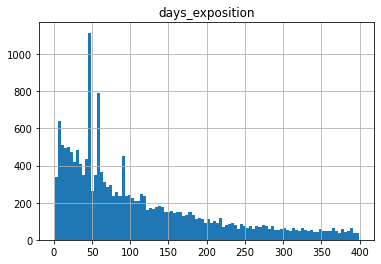

In [355]:
data.query('days_exposition < 400').hist('days_exposition', bins=100);

Всего данных о кол-ве дней - 20 204 шт.

Среднее кол-во дней - 180

Медианное кол-во дней - 95

Стандартное отклонение довольно высоко - 219

Вывод: Быстрыми можно считать продажи, которые заняли менее 45 дней, долгими - более 230 дней.
Чаще всего объявление выставлено около 120 дней

<H3> Что влияет на цену жилья</H3>



In [50]:
data_for_price = data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type', 'weekday_publicatin', 'month_publication', 'year_publication']]
data_for_price.corr()

,last_price,total_area,living_area,kitchen_area,rooms,weekday_publicatin,month_publication,year_publication
last_price,1.000000,0.759436,0.665425,0.558200,0.464563,-0.006471,0.010323,-0.051301
total_area,0.759436,1.000000,0.933279,0.582756,0.778980,-0.010372,0.011426,-0.082602
living_area,0.665425,0.933279,1.000000,0.376359,0.863273,-0.008455,0.000922,-0.071760
kitchen_area,0.558200,0.582756,0.376359,1.000000,0.232995,-0.009565,0.009909,-0.055343
rooms,0.464563,0.778980,0.863273,0.232995,1.000000,-0.005495,-0.000644,-0.051515
weekday_publicatin,-0.006471,-0.010372,-0.008455,-0.009565,-0.005495,1.000000,0.013849,-0.003103
month_publication,0.010323,0.011426,0.000922,0.009909,-0.000644,0.013849,1.000000,-0.272841
year_publication,-0.051301,-0.082602,-0.071760,-0.055343,-0.051515,-0.003103,-0.272841,1.000000


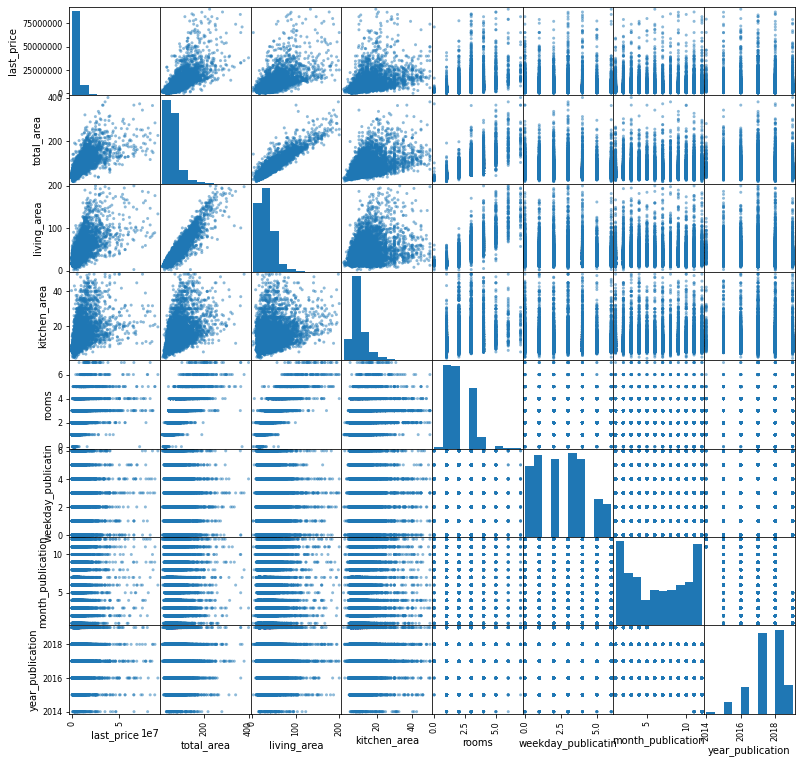

In [51]:
pd.plotting.scatter_matrix(data_for_price, figsize=(13, 13));

Из матрицы корреляций видно, что на цену жилья влияют:
- общая площадь жилья
- жилая площадь
- площадь кухни

Особонно тесна связь этих показателей у жилья, которое стоит до 25 млн. руб.
Больше всего, конечно, за цену жилья влияет его общая площадь.

<H3> Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений</H3>


In [52]:
top_locations = data['locality_name'].value_counts().head(10).to_frame()
top_locations = top_locations.reset_index()
top_locations.columns = ['locality_name', 'count']
top_locations = top_locations.merge(data, on='locality_name', how='left')
top_locations

,locality_name,count,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,...,ponds_around3000,ponds_nearest,days_exposition,living/total_area,metre_price,weekday_publicatin,month_publication,year_publication,floor_type,cityCenters_nearest_km
0,санкт-петербург,15483,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,...,2,755.0,NaN,0.472222,120370.37,3,3,2019,другой,16.0
1,санкт-петербург,15483,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,...,2,574.0,558.0,0.612500,92785.71,3,8,2015,другой,14.0
2,санкт-петербург,15483,0,64900000,159.0,2015-07-24,3,NaN,14,NaN,...,3,234.0,424.0,NaN,408176.10,4,7,2015,другой,7.0
3,санкт-петербург,15483,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,...,1,48.0,121.0,0.320000,100000.00,1,6,2018,другой,8.0
4,санкт-петербург,15483,5,7915000,71.6,2019-04-18,2,NaN,24,NaN,...,0,NaN,NaN,NaN,110544.69,3,4,2019,другой,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18731,выборг,235,7,2250000,43.0,2018-01-10,2,2.55,5,NaN,...,0,NaN,50.0,NaN,52325.58,2,1,2018,последний,NaN
18732,выборг,235,9,4600000,73.0,2016-07-27,3,3.00,7,NaN,...,0,NaN,1005.0,NaN,63013.70,2,7,2016,другой,NaN
18733,выборг,235,14,2250000,36.0,2017-10-14,1,2.50,5,17.0,...,0,NaN,425.0,0.472222,62500.00,5,10,2017,последний,NaN
18734,выборг,235,15,7490000,114.0,2018-08-13,4,3.15,4,81.3,...,0,NaN,245.0,0.713158,65701.75,0,8,2018,последний,NaN


In [53]:
mean_metre_price = top_locations.pivot_table(index='locality_name', values='metre_price', aggfunc='mean') 
mean_metre_price.sort_values(by='metre_price', ascending=False)

,metre_price
locality_name,
санкт-петербург,113275.170812
пушкин,102920.402901
деревня кудрово,92473.547559
поселок парголово,90205.423374
поселок мурино,85629.568641
поселок шушары,78551.344647
колпино,75352.475595
гатчина,68746.146515
всеволожск,68719.320378


Санкт-Петербург - город, с самой большой стоимостью квадратного метра. В то время, как г. Выборг - с самой низкой. 


                          last_price
cityCenters_nearest_km              
0.0                     2.199051e+07
1.0                     1.480346e+07
2.0                     1.427968e+07
3.0                     1.070004e+07
4.0                     1.120422e+07
5.0                     1.208911e+07
6.0                     1.302634e+07
7.0                     1.360686e+07
8.0                     9.055654e+06
9.0                     6.977974e+06
10.0                    6.418696e+06
11.0                    6.232649e+06
12.0                    5.826739e+06
13.0                    6.070949e+06
14.0                    5.599465e+06
15.0                    5.808007e+06
16.0                    5.376025e+06
17.0                    5.222683e+06
18.0                    5.100913e+06
19.0                    5.051410e+06
20.0                    5.870706e+06
21.0                    5.493469e+06
22.0                    5.415524e+06
23.0                    5.000798e+06
24.0                    3.854430e+06
2

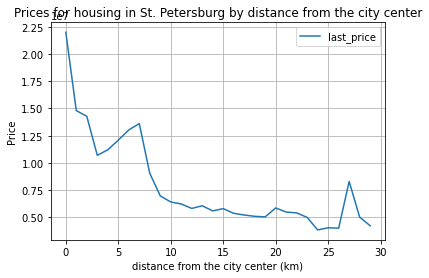

In [54]:
print(data[data['locality_name'] == 'санкт-петербург'].pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean'))
data[data['locality_name'] == 'санкт-петербург'].pivot_table(index='cityCenters_nearest_km', \
       values='last_price', aggfunc='mean').plot(grid=True, ylabel='Price', xlabel='distance from the city center (km)', \
       title='Prices for housing in St. Petersburg by distance from the city center');

В среднем, цена жилья тем меньше, чем дальше оно от центра города. Но, все таки, отдаленность недвижимости - не самый сильный фактор, влияюзий на ее цену, по крайней мере, в Санкт-Перертурге.

In [55]:
data.query('locality_name == "санкт-петербург" & cityCenters_nearest_km == 28')['total_area'].count()

7

В среднем снижение стоимости прослеживается, но оно не абсолютно точное. Например, на отдаллености в 22км и 28км цена жилья больше ожидаемого. Но это связано с небольшим кол-вом объявлений из этой местности. (в отдалении от города на 28 км в датасете представлено всего 7 шт).

# Общий вывод

Изначально количество предоставленных объявлений было 23 699.
Но из-за многочисленных пропусков показателей, необходимых для корректного исследования, некоторые пропуски были заменены медианными значениями. С данных о высоте потолков были встречены ошибки с неверной записью чисел с плавающей точкой. Такие значения были приведены в порядок, и неизвестные значения были заменения медианными.

Также, для корректности исследования, были удалены аномальные показатели (чрезвычайно низкие/высокие). В итоге, исследование велось на основе 23 337 объявлений о продажи жилья (удалили около 1.5%). Благодаря этому, изучаемые объявления типичны по своим показателям с большинством объявлений, и сокращение числа единиц совокупности только повысило точность анализа.

-----------------


На основе 20 204 объявлений были сделаны выводы:

1. В среднем, объявление держится 180 дней;
2. Чаще всего объявление выставлено около 95 дней
3. Быстрыми можно считать продажи, которые заняли менее 45 дней
4. Долгими можно считать продажи, которые ждали более 230 дней
--------------

На цену жилья влияют:

- общая площадь жилья (коэф. Пирсона - 0.76)
- жилая площадь (коэф. Пирсона - 0.67)
- площадь кухни (коэф. Пирсона - 0.56)

Особонно тесна связь этих показателей у жилья, которое стоит до 25 млн. руб.

Больше всего, конечно, на цену жилья влияет его общая площадь


---------------

По изучаемой выборке, Санкт-Петербург - город, с самой большой стоимостью квадратного метра. В то время, как г. Выборг - с самой низкой. 

В среднем, цена жилья тем меньше, чем дальше оно от центра города. Но, все таки, отдаленность недвижимости - не самый сильный фактор, влияющий на ее цену, по крайней мере, в Санкт-Петертурге.